In [1]:
# Basics
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Models
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Misc
import sys
from IPython.display import clear_output

%run utils/utils_metrics.py

### 1. Load data

In [2]:
n_chunks = 1
chunks = [pkl.load(open('../data/bin_chunks/ttd_chunk_{0}.pkl'.format(i), 'rb')) for i in range(1, n_chunks + 1)]
dataset = pd.concat(chunks)
print("Data shape:", dataset.shape)
dataset.head()

Data shape: (48605, 10)


,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


### 2. Preprocessing

### 2.1 Augmenting

In [3]:
dataset['estim_trip_distance'] = dataset.trip_ratio.median() * dataset.vec_dist
dataset.head()

,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio,estim_trip_distance
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387,10.458020
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648,1.361071
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070,0.728459
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045,1.286085
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123,1.344725


In [4]:
lat_data = np.array(pd.concat((dataset.pu_lat, dataset.do_lat))).reshape(-1,1)
lon_data = np.array(pd.concat((dataset.pu_lon, dataset.do_lon))).reshape(-1,1)
dur_data = np.array(dataset.duration.astype(float)).reshape(-1,1)

# New feature
etd_data = np.array(dataset.estim_trip_distance.astype(float)).reshape(-1,1)

scaler_type = 'StandardScaler' # Other options: MinMaxScaler
lat_scaler = getattr(preprocessing, scaler_type)()
lon_scaler = getattr(preprocessing, scaler_type)()
etd_scaler = getattr(preprocessing, scaler_type)()
out_scaler = getattr(preprocessing, scaler_type)()

# Inputs
lat_scaler.fit(lat_data);
lon_scaler.fit(lon_data);
etd_scaler.fit(etd_data)

# Output
out_scaler.fit(dur_data);

X = np.hstack((lat_scaler.transform(dataset[['pu_lat','do_lat',]]),
               lon_scaler.transform(dataset[['pu_lon','do_lon',]]),
               etd_scaler.transform(etd_data)))
y = out_scaler.transform(dur_data)

#### Quick look at inputs and output

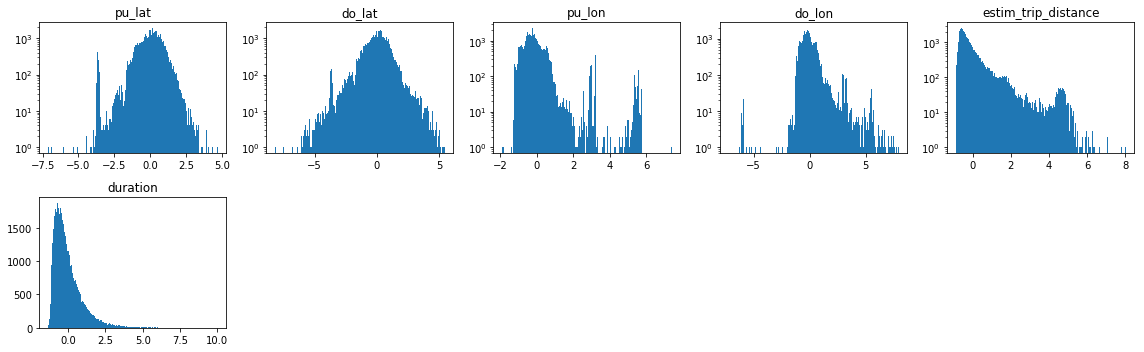

In [5]:
plt.figure(figsize=(16,5))
titles = ['pu_lat', 'do_lat', 'pu_lon', 'do_lon', 'estim_trip_distance', 'duration']
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.hist(X[:,i], bins='auto', log=True)
    plt.title(titles[i])
plt.subplot(2,5,6)
plt.hist(y, bins='auto')
plt.title(titles[-1])
plt.tight_layout()
plt.show()

### 3. Splitting data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

test_size = len(y_test)
train_size = len(y_train)

y_test_denorm = out_scaler.inverse_transform(y_test)

In [24]:
# # Store splitted data
pkl.dump(X_train, open('../splitted_data/fs1/x_train.dat', 'wb'))
pkl.dump(y_train, open('../splitted_data/fs1/y_train.dat', 'wb'))
pkl.dump(X_test, open('../splitted_data/fs1/x_test.dat', 'wb'))
pkl.dump(y_test, open('../splitted_data/fs1/y_test.dat', 'wb'))

In [6]:
# Read splitted data
X_train = pkl.load(open('../splitted_data/fs1/x_train.dat', 'rb'))
y_train = pkl.load(open('../splitted_data/fs1/y_train.dat', 'rb'))
X_test = pkl.load(open('../splitted_data/fs1/x_test.dat', 'rb'))
y_test = pkl.load(open('../splitted_data/fs1/y_test.dat', 'rb'))

test_size = len(y_test)
train_size = len(y_train)

y_test_denorm = out_scaler.inverse_transform(y_test)

### 4. SVM

In [11]:
kernels = ['linear', 'poly', 'rbf']
C_values = [0.1, 1, 10]

#### 4.1 Training

In [ ]:
for kern in kernels:
    for C in C_values:
        sys.stdout.write("\rTraining SVM with kernel {0} and C = {1}".format(kern,C))
        svm_reg = svm.SVR(kernel=kern, gamma='auto', C=C)
        svm_reg.fit(X_train, y_train.ravel())
        pkl.dump(svm_reg, open('../init_models/fs1/svms/svm_reg_{0}_{1}.mdl'.format(kern,C), 'wb'))
        sys.stdout.flush()
        clear_output()
sys.stdout.write("Done.")        

Training SVM with kernel poly and C = 10

#### 4.2 Testing

In [12]:
y_pred_svm = []
for kern in kernels:
    for C in C_values:
        print("Running tests on SVM with kernel {0} and C = {1}".format(kern,C))
        svm_reg = pkl.load(open('../init_models/fs1/svms/svm_reg_{0}_{1}.mdl'.format(kern,C), 'rb'))
        y_pred_svm.append(svm_reg.predict(X_test))
        sys.stdout.flush()
        clear_output()
sys.stdout.write("Done.")        

Done.

#### Denormalize predicited data

In [13]:
y_pred_svm_denorm = out_scaler.inverse_transform(y_pred_svm)

# Set all negative outputs to zero (we're predicting time)
y_pred_svm_denorm[y_pred_svm_denorm < 0] = 0

# Transform back again
y_pred_svm = out_scaler.transform(y_pred_svm_denorm)

#### 4.3 Metrics

In [16]:
idx = pd.MultiIndex.from_tuples([(k,C) for k in kernels for C in C_values], names=['Kernel','C'])

metrics_svm = compute_metrics(y_true = y_test, y_pred = y_pred_svm, 
                              y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_svm_denorm, 
                              indices = idx)  
metrics_svm

Exp. Var.        R2            MSE        RMSE      nMSE  \
Kernel C                                                                
linear 0.1    0.624054  0.616534  129311.100303  359.598527  0.375497   
       1.0    0.624039  0.616519  129315.990503  359.605326  0.375511   
       10.0   0.624053  0.616545  129307.278791  359.593213  0.375486   
poly   0.1    0.482639  0.469903  178757.360997  422.797068  0.519080   
       1.0    0.481397  0.468511  179226.711452  423.351759  0.520443   
       10.0   0.480066  0.467380  179608.197628  423.802074  0.521551   
rbf    0.1    0.687137  0.679690  108013.788297  328.654512  0.313653   
       1.0    0.698476  0.692158  103809.199706  322.194351  0.301444   
       10.0   0.700869  0.695253  102765.765752  320.571000  0.298414   

                nRMSE      MSLE     RMSLE  
Kernel C                                   
linear 0.1   0.612778  0.208027  0.456100  
       1.0   0.612790  0.208510  0.456629  
       10.0  0.612769  0.208561  0.456684  
poly   0.1   0.720472  0.402361  0.634320  
       1.0   0.721417  0.426354  0.652958  
       10.0  0.722185  0.439408  0.662878  
rbf    0.1   0.560047  0.154666  0.393277  
       1.0   0.549039  0.148271  0.385060  
       10.0  0.546273  0.146368  0.382580

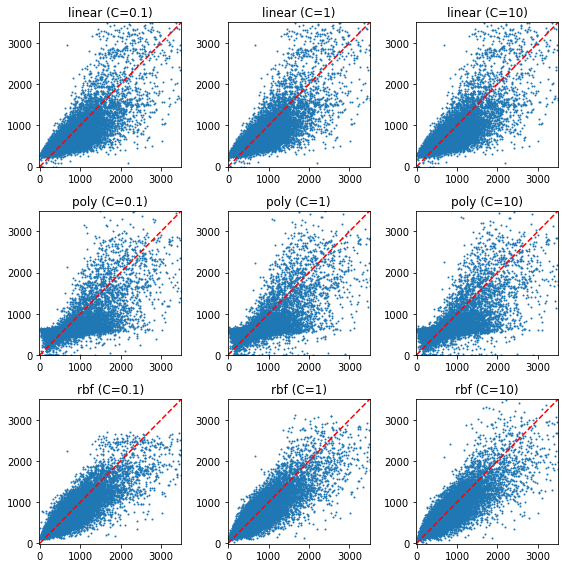

In [18]:
fig = plt.figure(figsize=(8,8))
for i,kern in enumerate(kernels):
    for j,C in enumerate(C_values):
        plt.subplot(3, 3, j + 3*i + 1)
        plt.scatter(y_test_denorm, y_pred_svm_denorm[j + 3*i], s = 1)
        plt.plot((-1,3500),(-1,3500), '--', c='r')
        plt.title('{0} (C={1})'.format(kern,C))
        plt.xlim((-10,3500))
        plt.ylim((-10,3500))
plt.tight_layout()
plt.show()

#### 4.4 Evaluate accuracy agains range of tolerance for best SVM

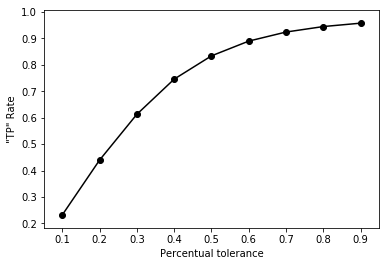

In [19]:
y_pred_svm_best = y_pred_svm_denorm[8].reshape(-1,1)

tolerance = np.arange(0.1,1,0.1)
acc = [np.sum(np.isclose(y_pred_svm_best, y_test_denorm, rtol=tol))/test_size for tol in tolerance]

plt.plot(tolerance, acc, c='k')
plt.scatter(tolerance, acc, c='k')
plt.ylabel('"TP" Rate')
plt.xlabel('Percentual tolerance')
plt.show()

### 5. Random Forests

In [20]:
forest_size = [50,100,150,200,250, 300]
max_feats   = [2,3,4]

#### 5.1 Training

In [8]:
for n_trees in forest_size:
    for max_feat in max_feats:
        sys.stdout.write("\rTraining forest with {0} trees using maximum of {1} features".format(n_trees, max_feat))
        rf_reg = RandomForestRegressor(n_estimators=n_trees, max_features=max_feat, n_jobs=2)
        rf_reg.fit(X_train, y_train.ravel())
        pkl.dump(rf_reg, open('../init_models/fs1/random_forests/rf_reg_{0}_{1}.mdl'.format(n_trees,max_feat), 'wb'))
        sys.stdout.flush()
clear_output()
sys.stdout.write("Done.")        

Done.

#### 5.2 Testing

In [22]:
y_pred_rf = []
for n_trees in forest_size:
    for max_feat in max_feats:
        sys.stdout.write("\rTesting forest with {0} trees using maximum of {1} features".format(n_trees, max_feat))
        rf_reg = pkl.load(open('../init_models/fs1/random_forests/rf_reg_{0}_{1}.mdl'.format(n_trees,max_feat), 'rb'))
        y_pred_rf.append(rf_reg.predict(X_test));
        sys.stdout.flush()
clear_output()
sys.stdout.write("Done.")        

Done.

#### Denormalize predicited data

In [25]:
y_pred_rf_denorm = out_scaler.inverse_transform(y_pred_rf)

# Set all negative outputs to zero (we're predicting time)
y_pred_rf_denorm[y_pred_rf_denorm < 0] = 0

# Transform back again
y_pred_rf = out_scaler.transform(y_pred_rf_denorm)

#### 4.3 Metrics

In [26]:
idx = pd.MultiIndex.from_tuples([(f,m) for f in forest_size for m in max_feats], names=['#Tress','MaxFeat'])

metrics_svm = compute_metrics(y_true = y_test, y_pred = y_pred_rf, 
                              y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_rf_denorm, 
                              indices = idx)  
metrics_svm

Exp. Var.        R2            MSE        RMSE      nMSE  \
#Tress MaxFeat                                                             
50     2         0.697101  0.696839  102230.928644  319.735717  0.296861   
       3         0.693014  0.692614  103655.608690  321.955911  0.300998   
       4         0.690086  0.689594  104673.764187  323.533251  0.303954   
100    2         0.698029  0.697677  101948.314275  319.293461  0.296040   
       3         0.697214  0.696740  102264.137613  319.787645  0.296957   
       4         0.693671  0.693167  103469.214066  321.666309  0.300457   
150    2         0.699473  0.699207  101432.149447  318.484143  0.294541   
       3         0.696496  0.696064  102492.022662  320.143753  0.297619   
       4         0.693702  0.693121  103484.497104  321.690064  0.300501   
200    2         0.700150  0.699805  101230.467152  318.167357  0.293956   
       3         0.697598  0.697149  102126.086266  319.571723  0.296556   
       4         0.695435  0.694910  102881.321754  320.751184  0.298749   
250    2         0.700089  0.699760  101245.941555  318.191674  0.294001   
       3         0.698538  0.698092  101808.133057  319.073868  0.295633   
       4         0.695017  0.694492  103022.074369  320.970519  0.299158   
300    2         0.701133  0.700813  100890.769701  317.633074  0.292969   
       3         0.697907  0.697432  102030.839556  319.422666  0.296280   
       4         0.695196  0.694690  102955.300084  320.866483  0.298964   

                   nRMSE      MSLE     RMSLE  
#Tress MaxFeat                                
50     2        0.544849  0.156711  0.395867  
       3        0.548633  0.160905  0.401129  
       4        0.551321  0.162038  0.402539  
100    2        0.544096  0.155531  0.394374  
       3        0.544938  0.157666  0.397072  
       4        0.548139  0.159798  0.399748  
150    2        0.542717  0.155474  0.394302  
       3        0.545545  0.157825  0.397272  
       4        0.548180  0.160519  0.400648  
200    2        0.542177  0.155043  0.393755  
       3        0.544570  0.157931  0.397406  
       4        0.546580  0.159312  0.399139  
250    2        0.542218  0.154979  0.393674  
       3        0.543721  0.157460  0.396812  
       4        0.546953  0.159006  0.398755  
300    2        0.541266  0.154722  0.393347  
       3        0.544316  0.157274  0.396578  
       4        0.546776  0.158646  0.398303

### 6. XGBoost

In [48]:
xgb_reg = xgb.XGBRegressor(n_estimators=300, max_depth=10)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [49]:
y_pred_xgb = xgb_reg.predict(X_test).reshape(1,-1)

In [50]:
y_pred_xgb_denorm = out_scaler.inverse_transform(y_pred_xgb)

# Set all negative outputs to zero (we're predicting time)
y_pred_xgb_denorm[y_pred_xgb_denorm < 0] = 0

# Transform back again
y_pred_xgb = out_scaler.transform(y_pred_xgb_denorm)

In [51]:
compute_metrics(y_true = y_test, y_pred = y_pred_xgb,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_xgb_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE
0,0.690634,0.690484,104373.769994,323.069296,0.303083,0.55053,0.158994,0.398741


### 7. Neural Network

In [52]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,4))

In [53]:
mlp_reg.fit(X_train, y_train.ravel())

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [54]:
y_pred_mlp = mlp_reg.predict(X_test).reshape(1,-1)

In [55]:
y_pred_mlp_denorm = out_scaler.inverse_transform(y_pred_mlp)

# Set all negative outputs to zero (we're predicting time)
y_pred_mlp_denorm[y_pred_mlp_denorm < 0] = 0

# Transform back again
y_pred_mlp = out_scaler.transform(y_pred_mlp_denorm)

In [56]:
compute_metrics(y_true = y_test, y_pred = y_pred_mlp,
                y_true_denorm = y_test_denorm, y_pred_denorm = y_pred_mlp_denorm,
                indices=[0])

,Exp. Var.,R2,MSE,RMSE,nMSE,nRMSE,MSLE,RMSLE
0,0.703413,0.703339,100039.040032,316.289488,0.290496,0.538977,0.156782,0.395958


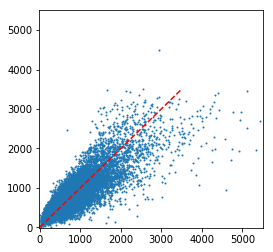

In [57]:
fig = plt.figure(figsize=(4,4))
plt.scatter(y_test_denorm, y_pred_mlp_denorm, s = 1)
plt.plot((-1,3500),(-1,3500), '--', c='r')
plt.xlim((-10,5500))
plt.ylim((-10,5500))
plt.show()